# mixture density networks 


- About density estimation: http://scikit-learn.org/stable/modules/density.html


- http://tullo.ch/articles/speeding-up-isotonic-regression/

We want to model the conditional distribution as a mixture of Gaussians, where each Gaussian component parameters are dependent on the input, that is 


\begin{equation}
P(y^m \mid x^m) = \sum_{k=1}^K \pi_k(x^m) \mathcal{N} \left( y^m \mid \mu_k(x^m) , \sigma_k^2(x^m) \right)
\end{equation}


In [13]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


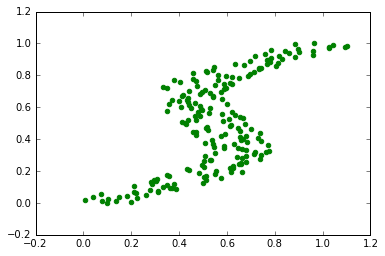

In [14]:
# generate some 1D regression data (reproducing Bishop book data, page 273). 
# Note that the P(y|x) is not a nice distribution.
# E.g. it has three modes for x ~= 0.5
N = 200
X = np.linspace(0,1,N)
Y = X + 0.3 * np.sin(2*3.1415926*X) + np.random.uniform(-0.1, 0.2, N)
X,Y = Y,X
plt.scatter(X,Y,color='g')

## About the model

Now we will present a mixture density network (MDN) with a single hidden layer. This model can be generalized using as many hidden layers as we want defined just like in a regular multilayer perceptron. The main difference between an standard MLP and a MDN is the output layer which will be specified in the following:

#### Weights

Let us assume we are training a MDN with $K$ Gaussian components and the objective is to build a density $P(t \mid x)$ where the target $t$ is a 1D variable (that is we are studying a 1D regression problem).

- First layer weights W1 defines a mapping from the input to the hidden layer.

- Second layer weights are composed by:

    - A weight matrix for the mixing coefficients $\pi_k$:  ```W_pi``` of shape ```(hidden_size, K)```
        
    - A weight matrix for the for the means of the Gaussian components $\mu_k$: ```W_mean``` of shape ```(hidden_size, K)```
    
    -  A weight matrix for the variances of the Gaussian components $\sigma_k^2$:  ```W_variance``` of shape ```(hidden_size, K)```

- Second layer biases are composed by:

    - A bias for the hidden layer: shape (hidden_size,1)
    
    - A bias for the mixing coefficients: shape (K,1)
    
    - A bias for the means of the Gaussian components: shape (K,1)
    
    - A bias for the variances of the Gaussian components: shape (K,1)


In [15]:
#from sklearn import utils, base
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils import check_array, check_X_y, column_or_1d
from sklearn.utils.extmath import safe_sparse_dot

In [16]:
help(safe_sparse_dot)

Help on function safe_sparse_dot in module sklearn.utils.extmath:

safe_sparse_dot(a, b, dense_output=False)
    Dot product that handle the sparse matrix case correctly
    
    Uses BLAS GEMM as replacement for numpy.dot where possible
    to avoid unnecessary copies.



In [17]:
np.random.randn(10,)

array([ 0.14390051, -0.17577744,  1.75482121, -0.94836317, -0.69809561,
       -0.98091346, -0.89505919,  0.91743192, -0.52511486, -0.04715616])

In [20]:
np.random.randn(5,1)

array([[-0.02456247],
       [ 0.66782762],
       [ 0.83379884],
       [-1.17220891],
       [ 1.96622617]])

In [21]:
def softmax(x):
    # softmaxes the columns of x
    #z = x - np.max(x, axis=0, keepdims=True) # for safety
    e = np.exp(x)
    en = e / np.sum(e, axis=0, keepdims=True)
    return en


In [23]:
class MDNRegressor(BaseEstimator, RegressorMixin):

    """
    Mixture density network regression. This version assumes
        - A single layer of hidden units.
        - Target variable to be 1-dimensional
    
    hidden_layer_sizes : tuple, length = n_layers - 2, default (100,)
 
       The ith element represents the number of neurons in the ith
       hidden layer.
       
    activation: {'tanh'}
    
    shuffle : bool, optional, default True
        Whether to shuffle samples in each iteration. 
        
    """
    
    def __init__(self,
                 hidden_layer_size,
                 n_components = 5,
                 activation="tanh",
                 batch_size= "auto",
                 shuffle=True):
        
        self.hidden_layer_size = hidden_layer_size
        self.n_components = n_components
        self.activation = activation
        self.batch_size = batch_size
        self.shuffle = shuffle
                
            
    def _initialize_in_fit(self, n_features, n_hidden, n_outputs, n_components):
        """
        Initialize the model weights and biases
        """
        scaling_factor = 0.1
        
        # n_outputs = y.shape[1]
        self.n_outputs_ = n_outputs
        
        # Initialize coefficient and intercept layers
        self.coefs_ = {'W_1': np.random.randn(n_features, n_hidden) * scaling_factor,
                       'W_variance': np.random.randn(n_hidden, n_components) * scaling_factor,
                       'W_mean': np.random.randn(n_hidden, n_components) * scaling_factor,
                       'W_mix_coeff':np.random.randn(n_hidden, n_components) * scaling_factor}
        
        self.intercepts_ = {'b_1':  np.zeros(n_hidden, ),
                            'b_variance': np.zeros(n_hidden, ),
                            'b_mean': np.zeros(n_hidden, ),
                            'b_mix_coeff':  np.zeros(n_hidden, )}
            
    def predict_statistics(self, X):
        """
        For each of the K components predicts
            - the expected value (mean of the Gaussian) for a given x
            - the variance of the prediction (variance of the Gaussian)
            - the weight or coefficient of the component
        """
        # compute hidden activation
        
        
    def _validate_hyperparameters(self):
        """
        Ensures hyperparameters are set correctly
        """
        if not isinstance(self.shuffle, bool):
            raise ValueError("shuffle must be either True or False, got %s." %
                             self.shuffle)       
    
    def _validate_input(self, X, y, incremental):
        
        if y.ndim == 2 and y.shape[1] == 1:
            y = column_or_1d(y, warn=True)
        return X,y
            
    def _forward_pass(self, X):
        activations = [X]
        

    def _compute_loss(self, act_means, act_variances, act_mixing_coeff)
        """
        Returns the probability
        """
        
        
    def _fit(self, X, y):
        """
        Train the model
        """
        ###########
        # Prepare #
        ###########
        
        # Do stuff here
        hidden_layer_size = self.hidden_layer_size
        
        # Validate input parameters.
        self._validate_hyperparameters()
        if np.any(np.array(hidden_layer_size) <= 0):
            raise ValueError("hidden_layer_sizes must be > 0, got %s." %
                             hidden_layer_size)
            
        # Validate input
        X, y = self._validate_input(X, y, incremental=True)
        
        # Ensure y is 2D
        if y.ndim == 1:
            y = y.reshape((-1, 1))            

        self.n_outputs_ = y.shape[1]
        n_features = X.shape[1]
        
        # Initialize model
        self._initialize_in_fit(n_features,
                                hidden_layer_size,
                                self.n_outputs_,
                                self.n_components)
        
        ###########
        # Train   #
        ###########
        
        ### Forward pass ###
        act_h1 = np.tanh( np.dot(X, self.coefs_['W_1']) + self.intercepts_['b_1']  )
        
        act_means = np.dot(m['W_mean'], act_h1) + m['b_mean']
        act_variances = np.exp(np.dot(m['W_variance'], act_h1) + m['b_variance'])
        act_mixing_coeff = softmax(np.dot(m['W_mix_coeff'], act_h1) + m['b_mix_coeff'])
        
        ###
        ### Compute Loss (- mean log-likelihood)
        ###
        n_components, n_samples = act_means.shape
        # prob_per_sample has shape (n_components, n_samples)
        prob_per_sample = np.exp(-((y - act_means)**2)/(2*act_variances**2))/(act_variances*np.sqrt(2*math.pi))
        pin = act_mixing_coeff * prob_per_sample
        # logprob has shape (1,n_samples)
        logprob = -np.log(np.sum(pin, axis=0, keepdims=True))
        loss = np.sum(logprob)/n_samples

        ###
        ### Gradients of the loss with respect to the parameters of the output layer
        ###
        gammas = pin / np.sum(pin, axis=0, keepdims = True)
        dmu = gammas * ((act_means - y)/sig**2) / n_samples
        dlogsig = gammas * (1.0 - (y-act_means)**2/(sig**2)) / n_samples
        dpiu = (pi - gammas) / n_samples
    
        grads = {}
        grads['W_mean'] = np.dot(dmu, act_h1.T)
        grads['W_variance'] = np.dot(dlogsig, act_h1.T)
        grads['W_mix_coeff'] = np.dot(dpiu, act_h.T)

        grads['b_mean'] = np.sum(dmu, axis=1, keepdims=True)
        grads['b_variance'] = np.sum(dlogsig, axis=1, keepdims=True)
        grads['b_mix_coeff'] = np.sum(dpiu, axis=1, keepdims=True)

        ### Gradients of the loss with respect to the parameters of the first layer
        dh = np.dot(m['Whu'].T, dmu) + np.dot(m['Whs'].T, dlogsig) + np.dot(m['Whp'].T, dpiu)
        dh = (1.0-h**2)*dh
        grads['W_1'] = np.sum(dh, axis=1, keepdims=True)       
        grads['b_1'] = np.dot(dh, x.T)
        
        
    def fit(self, X, y):
        return self._fit(X, y)

In [64]:
MDN =  MDNRegressor(hidden_layer_size=10)

In [65]:
X.shape, Y.shape

((200, 1), (200,))

In [66]:
X = X.reshape(-1,1)

In [67]:
X.shape, Y.shape

((200, 1), (200,))

In [68]:
MDN.fit(X,Y)

> <ipython-input-63-f1c590dc7750>(131)_fit()
-> return self
(Pdb) np.dot(X, self.coefs_["W_1"]).shape
(200, 10)
(Pdb) np.dot(X, self.coefs_["W_1"]) + self.intercepts_["b_1"]
array([[ 0.00339578, -0.00840269, -0.00056861, ..., -0.00355555,
         0.00258466, -0.00390758],
       [ 0.00238363, -0.00589818, -0.00039913, ..., -0.00249578,
         0.00181428, -0.00274289],
       [-0.00513246,  0.01270005,  0.00085941, ...,  0.00537395,
        -0.00390653,  0.00590603],
       ..., 
       [-0.03598199,  0.08903581,  0.00602502, ...,  0.03767495,
        -0.02738735,  0.04140518],
       [-0.03541653,  0.0876366 ,  0.00593034, ...,  0.03708289,
        -0.02695696,  0.04075449],
       [-0.04471425,  0.11064338,  0.0074872 , ...,  0.04681806,
        -0.03403382,  0.05145355]])
(Pdb) (np.dot(X, self.coefs_["W_1"]) + self.intercepts_["b_1"]).shape
(200, 10)
(Pdb) np.tanh( np.dot(X, self.coefs_["W_1"]) + self.intercepts_["b_1"]  )
array([[ 0.00339576, -0.00840249, -0.00056861, ..., -0.003

BdbQuit: 

In [34]:
n_hidden = 10
a = {"b_1":  np.zeros(n_hidden, 0)}

TypeError: data type not understood

In [39]:
a = {"b_1":  np.zeros(100, 0)}

TypeError: data type not understood

In [40]:
np.zeros(100, 0)

TypeError: data type not understood

In [43]:
np.zeros(100,)

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])